# Seismic Cubeset tutorial

Welcome! This notebook shows how to use `SeismicCubeset` class to hold information about .sgy/.hdf5 cubes. Also, utilitary class `SeismicGeometry` is demonstrated.

In [1]:
# Necessary modules
import os
import sys
from glob import glob

sys.path.append('..')
from seismiqb.batchflow import FilesIndex
from seismiqb import SeismicGeometry, SeismicCubeset

## First of all, lets create instance of `SeismicCubeset` from `FilesIndex`:

In [2]:
path_data_0 = '/notebooks/SEISMIC_DATA/CUBE_1/E_anon.sgy'
path_data_1 = '/notebooks/SEISMIC_DATA/CUBE_3/P_cube.sgy'
path_data_2 = '/notebooks/SEISMIC_DATA/CUBE_VUONGMK/Repaired_cube.sgy'

dsi = FilesIndex(path=[path_data_0, path_data_1, path_data_2], no_ext=True)
ds = SeismicCubeset(dsi)

print(ds.indices)

['E_anon' 'P_cube' 'Repaired_cube']


#### `SeismicGeometry` class is used as a container for lots of information: cube shapes, exact coordinates, minimum/maximum value in cube and so on. To get it, use method `load_geometries`:

In [3]:
ds = ds.load_geometries(scalers=True)
# ~ 11 minutes

Working with CUBE_VUONGMK/Repaired_cube.sgy: 100%|██████████| 2031360/2031360 [00:29<00:00, 69041.53it/s]
Making scalers for CUBE_VUONGMK/Repaired_cube.sgy: 100%|██████████| 2031360/2031360 [00:47<00:00, 42457.58it/s]


Wow, that takes a lot of time! Even considering total size of cubes, which is almost 100GB, that is bit too much..

**Note:** `load_geometries` makes one full pass through every cube in index. That is why it takes a lot of time, but, at the same time, it does not load more than one trace at a time in memory.

Don't worry though: by the end of this tutorial you will learn how to do it 1000 times faster!



#### Now, lets use not only cubes, but labeled horizonts.

Next two methods, `load_point_clouds` and `load_labels` result in creating `numba.Dict` with mapping from (iline, xline) to heights of horizonts. You need to pass mapping from cube names in index to location of .txt files to `load_point_clouds`.

**Note:** due to big amount of .txt files with labels for every cube it is crucial to have well-thought-out file structure.

In [4]:
paths_txt = {ds.indices[0]: glob('/notebooks/SEISMIC_DATA/CUBE_1/HORIZONTS/*.txt'),
             ds.indices[1]: glob('/notebooks/SEISMIC_DATA/CUBE_3/HORIZONTS/*.txt'),
             ds.indices[2]: glob('/notebooks/SEISMIC_DATA/CUBE_VUONGMK/HORIZONTS/*.txt')}

ds = (ds.load_point_clouds(paths = paths_txt)
        .load_labels())


#### As we know, many cubes are not fully-labeled: some of ilines/xlines are missing. It might be a good idea to check where labels are present, and where not:

**Note:** argument to `show_labels` is cube identificator from index of `Cubeset`, not path to the file itself.

Showing labels from above for Repaired_cube


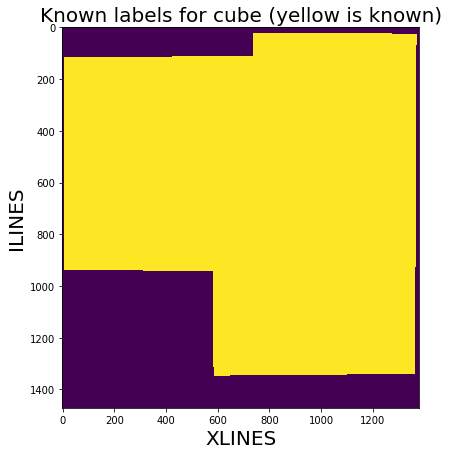

In [5]:
ds.show_labels('Repaired_cube')

Looks like a lot of absent labels! If we are to cut crops from places without labels and train neural network on it, it would be detrimental to its quality.

#### That is why we provide `load_samplers` method: it creates instance of `Sampler`, that generates points from labeled places (or very close to them).

**Note:** default behaviour is to sample points with equal probability from every cube, according to this cube labels destribution. You can also change proportion between cubes or use different sampling strategy. To learn more about this, check [documentation.](https://github.com/analysiscenter/seismiqb/blob/master/seismiqb/src/cubeset.py#L158)

In [6]:
ds = ds.load_samplers()

_ = [print(item) for item in ds.sampler.sample(5)]

['P_cube' 0.3606150565934787 0.40971822648502304 0.2842915456421414]
['E_anon' 0.1864258474657425 0.8034747284888155 0.3609639398234168]
['E_anon' 0.7417793939615868 0.08899496781997508 0.7311262409395584]
['Repaired_cube' 0.23042543223427098 0.9012162747107946
 0.21384487076670539]
['Repaired_cube' 0.43748804008425424 0.7360380757063698 0.4993298427927187]


As you can see, each sampled point contains reference to cube it was cut from. That is necessary so that further methods know from where to load data.

Next three values are iline, xline, and height, scaled to [0, 1] range. That is done in order to abstract from different shapes of each cube and use one common syntax for all of them.

#### Lets look on some of the attributes of our `Cubeset`:

In [7]:
print('\nGeometries:')
_ = [print(key, type(value)) for key, value in ds.geometries.items()]

print('\nPoint clouds:')
_ = [print(key, type(value)) for key, value in ds.point_clouds.items()]

print('\nLabels:')
_ = [print(key, type(value)) for key, value in ds.labels.items()]

print('\nSamplers:')
_ = [print(key, type(value)) for key, value in ds.samplers.items()]


Geometries:
E_anon <class 'seismiqb.src.geometry.SeismicGeometry'>
P_cube <class 'seismiqb.src.geometry.SeismicGeometry'>
Repaired_cube <class 'seismiqb.src.geometry.SeismicGeometry'>

Point clouds:
E_anon <class 'numpy.ndarray'>
P_cube <class 'numpy.ndarray'>
Repaired_cube <class 'numpy.ndarray'>

Labels:
E_anon <class 'numba.typed.typeddict.Dict'>
P_cube <class 'numba.typed.typeddict.Dict'>
Repaired_cube <class 'numba.typed.typeddict.Dict'>

Samplers:
E_anon <class 'seismiqb.batchflow.batchflow.sampler.Sampler'>
P_cube <class 'seismiqb.batchflow.batchflow.sampler.Sampler'>
Repaired_cube <class 'seismiqb.batchflow.batchflow.sampler.Sampler'>


#### Each of those entity is mapping from cube identificator. We provide methods to store them: for example, `save_point_clouds` does exactly what you would expect:

In [8]:
path_pc_saved = '/notebooks/SEISMIC_DATA/SAVED/DEMO/point_clouds.dill'
ds = ds.save_point_clouds(save_to=path_pc_saved)

#### To load entity from disk, pass `load_from` argument to `load_point_clouds` method.

In [9]:
%%time
ds = ds.load_point_clouds(load_from=path_pc_saved)

CPU times: user 256 ms, sys: 1.9 s, total: 2.15 s
Wall time: 2.15 s


**Note:** similar functionality is present for `load_geometries`, `load_labels` and `load_samplers`.

# HDF5
Storing created geometries, labels and samplers is definetely faster, than inferring them every time. That does not mean that there is no room to improve!

#### First of all, lets convert our .sgy cubes to .hdf5 format

**Note:** by default, cubes in new format saved on disk right next to their .sgy counterpart.

In [ ]:
ds = ds.convert_to_h5py()

It takes some time, but this method needs to be called only once.

#### Lets check how `load_geometries` fares:

In [10]:
%%time
path_data_0 = '/notebooks/SEISMIC_DATA/CUBE_1/E_anon.hdf5'
path_data_1 = '/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5'
path_data_2 = '/notebooks/SEISMIC_DATA/CUBE_VUONGMK/Repaired_cube.hdf5'

dsi = FilesIndex(path=[path_data_0, path_data_1, path_data_2], no_ext=True)
ds = SeismicCubeset(dsi)

ds = ds.load_geometries()

CPU times: user 560 ms, sys: 236 ms, total: 796 ms
Wall time: 788 ms


Almost instant!